In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = ('/content/drive/MyDrive/xihelm/train')

In [ ]:
IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels

In [ ]:
TRAINING_DATA_DIR = str(data)

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

In [ ]:
#Training and validation generation
import tensorflow as tf
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

In [ ]:
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset='validation',
shuffle=True,
target_size=IMAGE_SHAPE)

Found 60 images belonging to 3 classes.


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset='training',
shuffle=True,
target_size=IMAGE_SHAPE)

Found 240 images belonging to 3 classes.


In [ ]:
#Data viz
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 3))

Images are in size of 324 x 324 and Channel number is 3(RGB) with batch size = 32

In [ ]:
label_batch[0:10]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
print (train_generator.class_indices)

{'animals': 0, 'buildings': 1, 'landscapes': 2}


In [ ]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt','w')as f:
  f.write(labels)
!cat labels.txt

animals
buildings
landscapes

In [ ]:
pip install tensorflow-hub

In [ ]:
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

In [ ]:
#Classification with pretarined model(Transfer learning) from TFHUB
model = tf.keras.Sequential([hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4',
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes,activation = 'softmax')
])
model.build([32,224,224,3])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (32, 1280)                2257984   
_________________________________________________________________
dropout (Dropout)            (32, 1280)                0         
_________________________________________________________________
dense (Dense)                (32, 3)                   3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#Compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
import numpy as np

In [ ]:
#Training
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
    train_generator,
    epochs = 100,
    verbose=1,
    steps_per_epoch = steps_per_epoch,
    validation_data = valid_generator,
    validation_steps = val_steps_per_epoch).history

Epoch 1/100
8/8 [==============================] - 3s 359ms/step - loss: 0.0533 - acc: 0.9708 - val_loss: 0.3452 - val_acc: 0.8833
Epoch 2/100
8/8 [==============================] - 3s 323ms/step - loss: 0.0345 - acc: 0.9875 - val_loss: 0.3519 - val_acc: 0.8833
Epoch 3/100
8/8 [==============================] - 3s 337ms/step - loss: 0.0369 - acc: 0.9750 - val_loss: 0.3627 - val_acc: 0.8667
Epoch 4/100
8/8 [==============================] - 3s 315ms/step - loss: 0.0231 - acc: 0.9875 - val_loss: 0.3718 - val_acc: 0.8667
Epoch 5/100
8/8 [==============================] - 3s 319ms/step - loss: 0.0292 - acc: 0.9875 - val_loss: 0.3937 - val_acc: 0.8667
Epoch 6/100
8/8 [==============================] - 3s 311ms/step - loss: 0.0515 - acc: 0.9792 - val_loss: 0.4160 - val_acc: 0.8500
Epoch 7/100
8/8 [==============================] - 2s 312ms/step - loss: 0.0238 - acc: 0.9917 - val_loss: 0.4188 - val_acc: 0.8667
Epoch 8/100
8/8 [==============================] - 2s 309ms/step - loss: 0.0443 - a

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('final accuracy:{:.2f}%'.format(final_accuracy * 100))

2/2 [==============================] - 1s 231ms/step - loss: 0.3662 - acc: 0.8833
Final loss: 0.37
final accuracy:88.33%


In [ ]:
import matplotlib.pyplot as plt

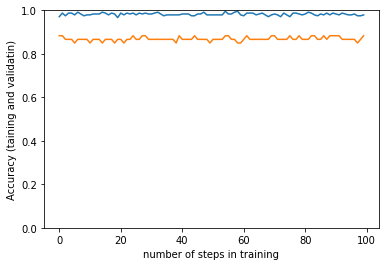

In [ ]:
plt.figure()
plt.ylabel('Accuracy (taining and validatin)')
plt.xlabel('number of steps in training')
plt.ylim([0,1])
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

The blue line is accuracy and orange is validation

In [ ]:
##Perfomance evaluation
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print('Validation batch shape:', val_image_batch.shape)

Validation batch shape: (28, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Animals' 'Buildings' 'Landscapes']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (28, 3)


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Buildings' 'Animals' 'Animals' 'Landscapes' 'Landscapes' 'Landscapes'
 'Buildings' 'Landscapes' 'Buildings' 'Buildings' 'Landscapes' 'Animals'
 'Buildings' 'Landscapes' 'Animals' 'Animals' 'Landscapes' 'Buildings'
 'Landscapes' 'Animals' 'Buildings' 'Buildings' 'Buildings' 'Animals'
 'Buildings' 'Landscapes' 'Animals' 'Buildings']


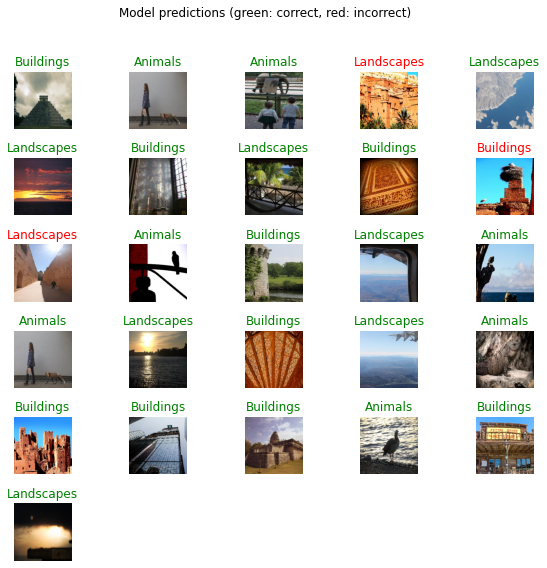

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
